**Arabic POS tagging**

by/ Ahmed Essam 


**Objective:**
The objective is to perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.


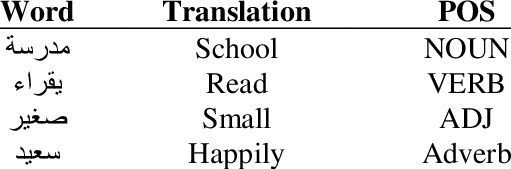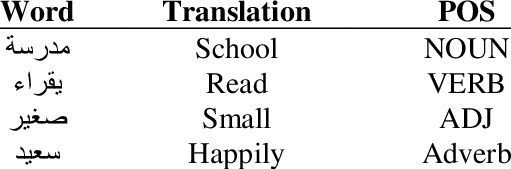

**Evaluation metric:**
Accuracy

**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Arabic POS.conllu". You can use pyconll library
   - Preprocess the data as necessary, including tokenization

2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging. You may consider using recurrent layers such as (LSTM) or (GRU).
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.

3. **Training:**

4. **Evaluation:**

### Import used libraries

In [1]:
!pip install conllu
!pip install keras

In [2]:
!pip install tensorflow

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pandas as pd
from conllu import parse
import os
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import make_scorer,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

### Load Dataset

In [4]:
file_path = r"D:/projects/POS_tagging/UD_Arabic-PADT-master/ar_padt-ud-train.conllu"

with open(file_path, 'r', encoding='utf-8') as file:
    sentences = parse(file.read())

data = []
for sentence in sentences:
    for token in sentence:

        data.append({
            'Sentence #': token['id'],
            'WORD': token['form'],
            'POS': token['upostag']
        })

df = pd.DataFrame(data)

df

,Sentence #,WORD,POS
0,1,برلين,X
1,2,ترفض,VERB
2,3,حصول,NOUN
3,4,شركة,NOUN
4,5,اميركية,ADJ
...,...,...,...
254379,33,بنية,NOUN
254380,34,ه,PRON
254381,35,التحتية,ADJ
254382,36,"""",PUNCT


In [5]:
print("Unique words in corpus:", df['WORD'].nunique())
print("Unique tags in corpus:", df['POS'].nunique())

Unique words in corpus: 33496
Unique tags in corpus: 18


- We have various POS such as "PUNCT" which represents punctuation marks, and "NOUN", "VERB", "ADJ", and "ADP" represent nouns, verbs, adjectives, and adpositions.
- Here is a reference table outlining the meanings of different Parts of Speech (POS) tags exist in the data:

| POS   | Meaning                                                   |
|-------|-----------------------------------------------------------|
| NOUN  | Person, place, thing, or idea                             |
| ADP   | Preposition or postposition                                |
| ADJ   | Modifies or describes a noun or pronoun                   |
| PUNCT | Punctuation marks                                         |
| VERB  | Expresses an action, occurrence, or state of being        |
| CCONJ | Coordinating conjunction                                  |
| X     | Placeholder or symbol                                     |
| PRON  | Substitutes for a noun or noun phrase                     |
| NUM   | Number                                                    |
| DET   | Introduces a noun and expresses reference                 |
| SCONJ | Introduces subordinate clauses                            |
| PART  | Grammatically functional word not fitting major categories|
| AUX   | Auxiliary verb                                            |
| ADV   | Modifies a verb, adjective, adverb, clause, or sentence  |
| SYM   | Mathematical or logical symbol                            |
| PROPN | Proper noun                                               |
| INTJ  | Interjection expressing emotion or sentiment              |


In [294]:
df.shape

(223881, 3)

In [295]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      33617
ADJ      23498
PUNCT    17511
VERB     16789
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

- NOUN is the most frequent POS tag (74546) , followed by ADP (33617) and ADJ (23498).

### Cleaning and Preprocessing

In [6]:
def clean_str(text):

    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    
    # Text normalization

    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel, "", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    text = text.replace('أ', 'ا')
    text = text.replace('إ', 'ا')
    text = text.replace('آ', 'ا')
    text = text.replace('ى', 'ي')
    text = re.sub("[إأآااً]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub("ڤ", "ف", text)
    text = re.sub("چ", "ج", text)
    text = re.sub("ژ", "ز", text)
    text = re.sub("پ", "ب", text)
    
    return text

In [7]:
# Clean each token in corpus to obtain unique words
cleaned_tokens = list(map(clean_str,df['WORD']))

cleaned_tokens[:5]

['برلين', 'ترفض', 'حصول', 'شركه', 'اميركيه']

In [8]:
unique_tokens = set(cleaned_tokens)
print("Number of unique tokens:",len(unique_tokens))

Number of unique tokens: 31206


In [9]:
df['CLEAN_WORDS'] = cleaned_tokens

In [10]:
df.head()

,Sentence #,WORD,POS,CLEAN_WORDS
0,1,برلين,X,برلين
1,2,ترفض,VERB,ترفض
2,3,حصول,NOUN,حصول
3,4,شركة,NOUN,شركه
4,5,اميركية,ADJ,اميركيه


In [11]:
# Before removing duplicates
df.shape

(254384, 4)

In [12]:
df.duplicated(subset=['CLEAN_WORDS','POS']).sum()

220607

In [13]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      33617
_        30485
ADJ      23498
PUNCT    17511
VERB     16807
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

In [14]:
df.loc[df['POS']=='SCONJ','POS'] = 'ADP'

- We can comibne SCONJ with the ADP (Preposition or Postposition) class to prevent causing errors.

In [15]:
df.loc[df['POS']=='SYM']

,Sentence #,WORD,POS,CLEAN_WORDS
1129,27,%,SYM,%
1493,10,%,SYM,%
1556,19,%,SYM,%
1561,24,%,SYM,%
1600,10,%,SYM,%
...,...,...,...,...
214616,28,/,SYM,/
216373,17,/,SYM,/
217141,16,/,SYM,/
217145,20,/,SYM,/


In [16]:
df.tail()

,Sentence #,WORD,POS,CLEAN_WORDS
254379,33,بنية,NOUN,بنيه
254380,34,ه,PRON,ه
254381,35,التحتية,ADJ,التحتيه
254382,36,"""",PUNCT,""""
254383,37,.,PUNCT,.


- We can add more symbols to balance the data

### Retrieve Sentences and Corresponsing Pos

In [17]:
import pandas as pd

class SentenceGetter:
    def __init__(self, data):
        self.data = data
        self.sentences = self._get_sentences()

    def _get_sentences(self):
        # Group words and tags by sentence and store as a list of lists
        sentences = []
        current_sentence = []
        current_id = None

        for _, row in self.data.iterrows():
            sentence_id = row["Sentence #"]
            word, tag = row["CLEAN_WORDS"], row["POS"]

            # Check if we are still in the same sentence
            if sentence_id != current_id:
                # If not, add the completed sentence to sentences and start a new one
                if current_sentence:
                    sentences.append(current_sentence)
                current_sentence = [(str(word), str(tag))]
                current_id = sentence_id
            else:
                current_sentence.append((str(word), str(tag)))

        # Add the last sentence if it exists
        if current_sentence:
            sentences.append(current_sentence)

        return sentences

    def get_next(self):
        # Retrieve sentences one at a time
        if self.sentences:
            return self.sentences.pop(0)
        else:
            return None

# Sample DataFrame setup
additional_symbols = pd.DataFrame({
    'Sentence #': ['Sentence: 6074']*5, 
    'WORD': ['-', '>', '*', '=', '^'],
    'POS': ['SYM']*5,  
    'CLEAN_WORDS': ['-', '>', '*', '=', '^']  
})

# Concatenate with an existing DataFrame `df` if it exists; otherwise, use `additional_symbols`
# Assuming `df` exists, or uncomment the line below if working with `additional_symbols` alone
# df = additional_symbols

df = pd.concat([df, additional_symbols], axis=0, ignore_index=True)

# Initialize SentenceGetter
getter = SentenceGetter(df)

# Retrieve all sentences, flatten them, and print the result
flattened_sentences = [pair for sentence in getter.sentences for pair in sentence]

# Display flattened sentences
print("Collected sentences:", flattened_sentences[0])


Collected sentences: ('برلين', 'X')


In [18]:
words = list(set(df["CLEAN_WORDS"].values))
words.append("ENDPAD")
num_words = len(words)
num_words

31210

In [19]:
pos = list(set(df["POS"].values))
num_pos = len(pos)

### Define Mappings between Sentences and Pos

* Create tokens and POS encoders

In [20]:
# starting from 1 , to set 0 default index for out of vocab
word2idx = {w: i + 1 for i, w in enumerate(words)}
pos2idx = {t: i for i, t in enumerate(pos)}

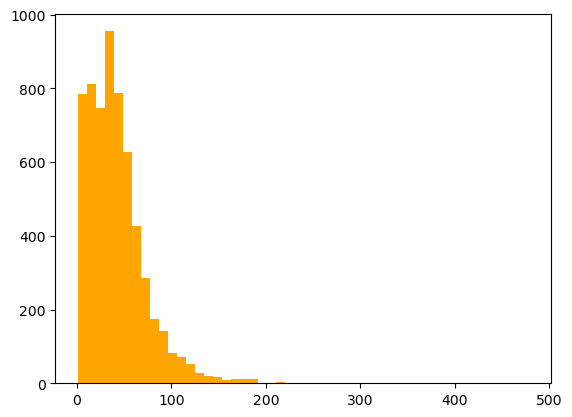

In [21]:
plt.hist([len(s) for s in sentences], bins=50, color = 'orange')
plt.show()

- Setting max_len to be 25.

In [318]:
max_len = 150

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value = num_words-1) # Index of ENDPAD

y = [[pos2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value = pos2idx['X'] )

In [319]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelling

- Assigning `return_sequences=True` is a must, to enable the subsequent layer "TimeDistributed" to receive and process information from each time step, where each input token needs to be associated with an output label.

In [320]:
input_word = Input(shape=(max_len,))

# Embedding layer to convert input word to vectors
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)

# Bidirectional LSTM layer to capture context from both directions , 
model = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))(model)

# TimeDistributed layer to apply Dense layer to each time step independently
out = TimeDistributed(Dense(num_pos, activation="softmax"))(model)

model = Model(input_word, out)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 150, 50)        │     1,030,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 150, 100)       │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 150, 16)        │         1,616 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,866 (4.09 MB)

 Trainable params: 1,072,866 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [321]:
# Using "sparse_categorical_crossentropy" instead of one hot encode labels
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [322]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=50,
    callbacks=[early_stopping])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 366ms/step - accuracy: 0.7768 - loss: 0.9143 - val_accuracy: 0.8946 - val_loss: 0.3648
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.9099 - loss: 0.2985 - val_accuracy: 0.9521 - val_loss: 0.1603
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.9627 - loss: 0.1344 - val_accuracy: 0.9795 - val_loss: 0.0783
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.9855 - loss: 0.0645 - val_accuracy: 0.9844 - val_loss: 0.0568
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 354ms/step - accuracy: 0.9910 - loss: 0.0405 - val_accuracy: 0.9852 - val_loss: 0.0494
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 356ms/step - accuracy: 0.9924 - loss: 0.0312 - val_accuracy: 0.9860 - val_loss: 0.0465
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 357ms/step - accuracy: 0.9932 - loss: 0.0256 - val_accuracy: 0.9862 - val_loss: 0.0450
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 360ms/step - accuracy: 0.9934 - loss: 0

#### Evaluation

**Evaluation metric:**
Accuracy

In [324]:
# Loss and precision on validation data 
evaluation_metrics = model.evaluate(x_test,
                                    y_test, verbose=0)
loss = evaluation_metrics[0]
acc = evaluation_metrics[1]

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test Loss: 0.044051289558410645
Test Accuracy: 0.9864582419395447


In [325]:
x_test.shape

(1215, 150)

In [326]:
# Generate predictions using the trained model on the test dataset.
predictions= model.predict(x_test, verbose=0)

In [327]:
# Select the class with the highest probability as the predicted pos
predicted_labels = np.argmax(predictions, axis=-1)

In [328]:
print('Test shape:',x_test.shape)
print('Predictions shape:', predictions.shape)

Test shape: (1215, 150)
Predictions shape: (1215, 150, 16)


In the case of POS tagging, the predictions tensor has shape (no_samples, sequence_length, num_classes).
* Where:
    * no_samples is the number of samples in the batch.
    * sequence_length is the length of each sequence.
    * num_classes is the number of classes (the number of POS tags -16- ).
* By setting axis=-1, we compute the argmax along the last axis, which corresponds to the num_classes axis. This means that for each element in the batch and for each position in the sequence, np.argmax will return the index of the class with the highest probability.

In [329]:
# Ignore zeros to prevent biased evaluation
mask = y_test.flatten() != pos2idx['X']
y_test_flat = y_test.flatten()[mask]
predicted_labels_flat = predicted_labels.flatten()[mask]

In [330]:
print(classification_report(y_test_flat ,predicted_labels_flat, zero_division=1))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       343
           1       1.00      0.99      0.99      3205
           2       0.96      0.90      0.93      3307
           3       0.98      1.00      0.99      7408
           4       0.86      0.80      0.83       333
           5       1.00      1.00      1.00      3586
           6       1.00      0.90      0.94      1212
           7       0.95      0.91      0.93      4784
           8       0.98      0.96      0.97       894
           9       0.92      0.32      0.48        37
          10       0.99      0.87      0.93       182
          11       1.00      0.94      0.97        50
          12       1.00      0.00      0.00         1
          13       1.00      0.99      0.99      1686
          14       0.96      0.96      0.96     14893
          15       0.00      1.00      0.00         0

    accuracy                           0.96     41921
   macro avg       0.91   

In [331]:
metrics = pd.DataFrame(history.history)

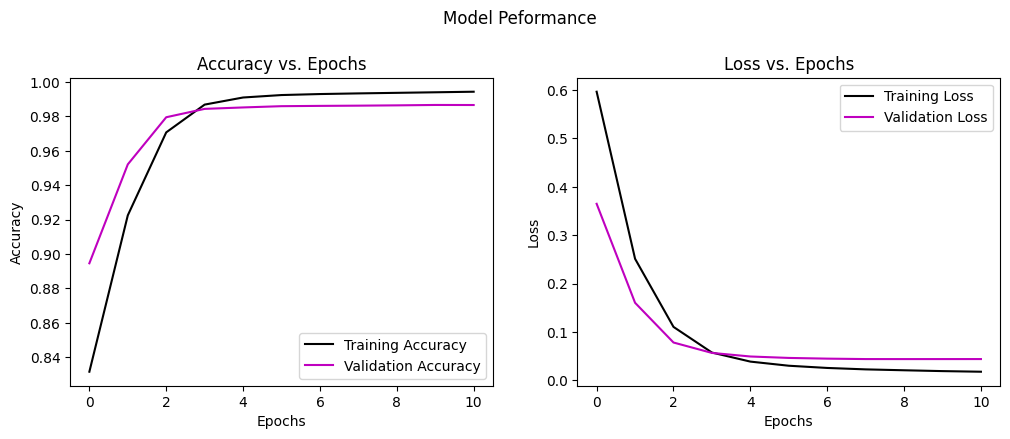

In [332]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy',color='k')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy',color='m')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss',color='k')
plt.plot(metrics['val_loss'], label='Validation Loss',color='m')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.suptitle('Model Peformance', y = 1.05)
plt.show()

### Conclusion and final results


In [333]:
def predict(text):
    max_len = 150
    str_len = len(text.split())
    # 0 is the default index for unknown pos
    text = clean_str(text)
    text = [[word2idx[w] for w in text.split() if w != "ENDPAD"]]
    text = pad_sequences(maxlen=max_len, sequences=text, padding="post",value = num_words-1)
    p = model.predict(np.array([text[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}\t {}\n".format("Word", "Pred"))
    print("-" *30)
    for i in range(str_len):
        print("{:15}\t{}".format(words[text[0][i]-1], pos[p[0][i]]))

In [334]:
text ='برلين ترفض حصول شركة اميركية على رخصة تصنيع دبابة " ليوبارد " الالمانية'
predict(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Word           	 Pred

------------------------------
برلين          	X
ترفض           	VERB
حصول           	NOUN
شركه           	NOUN
اميركيه        	ADJ
علي            	ADP
رخصه           	NOUN
تصنيع          	NOUN
دبابه          	NOUN
"              	PUNCT
ليوبارد        	X
"              	PUNCT
الالمانيه      	ADJ
